In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from typing import List, Tuple

In [2]:
EPS = 1e-8


def same_line(p: np.array, q: np.array) -> bool:
    # p = (A, B, C) means Ax + By + C = 0
    return abs(p[0] * q[1] - p[1] * q[0]) < EPS and abs(p[0] * q[2] - p[2] * q[0]) < EPS

In [3]:
def up_left(pos: np.array, dir: np.array, fa_width, width):
    # dir should be unit
    left_dir = np.array([-dir[1], dir[0]])
    return pos + dir * fa_width + left_dir * width


def up_right(pos: np.array, dir: np.array, fa_width, width):
    right_dir = np.array([dir[1], -dir[0]])
    return pos + dir * fa_width + right_dir * width


def dir_left(dir: np.array):
    return np.array([-dir[1], dir[0]])


def normalized(v: np.array):
    return v / norm(v)

In [4]:
def line_cross(a: np.array, b: np.array):
    x = (a[1] * b[2] - a[2] * b[1]) / (a[0] * b[1] - a[1] * b[0])
    y = (a[2] * b[0] - a[0] * b[2]) / (a[0] * b[1] - a[1] * b[0])
    return np.array([x, y])

In [5]:
class Node:
    def __init__(self, pos, subtree_width=None, sons=[]):
        self.pos = pos
        self.subtree_width = subtree_width  # 子树的水管距中线距离
        self.sons: List[Node] = sons

In [6]:
def line_at_dir(at: np.array, dir: np.array):
    a = -dir[1]
    b = dir[0]
    c = -a * at[0] - b * at[1]
    return np.array([a, b, c])

In [7]:
def dfs(u: Node, up_width, up_dir: np.array, lines: List[np.array], root=False, verbose=False):
    if root and up_dir is None:
        assert len(u.sons) == 1
        up_dir = normalized(np.array(u.sons[0].pos) - np.array(u.pos))

    width = u.subtree_width if u.subtree_width is not None else up_width

    def lines_append(line):
        if len(lines) > 0 and same_line(lines[-1], line):
            return
        lines.append(line)

    # 按照与 up_dir 极角从小到大排序
    if len(u.sons) > 1:
        def cmp(v):
            dir = np.array(v.pos) - np.array(u.pos)
            dir = dir / norm(dir)
            x, y = dir @ up_dir, dir @ dir_left(up_dir)
            return np.arctan2(y, x)
        u.sons.sort(key=cmp)

    for v in u.sons:
        dir = np.array(v.pos) - np.array(u.pos)
        dir = dir / norm(dir)
        line = line_at_dir(u.pos, dir)
        a, b, c = line
        if verbose:
            print(f'{u.pos} -> {v.pos}')
        lines_append(np.array([a, b, c + width / 2.0]))  # dir 右边
        dfs(v, width, dir, lines)
        if verbose:
            print(f'{u.pos} <- {v.pos}')
        lines_append(np.array([a, b, c - width / 2.0]))  # dir 左边

    if len(u.sons) == 0:
        lines_append(line_at_dir(u.pos + up_dir * width / 2.0,
                     dir_left(up_dir)))

    if root:  # root
        up_dir_left = dir_left(up_dir)
        lines_append(line_at_dir(u.pos, up_dir_left))

len n1.sons 1
[array([-0.70710678,  0.70710678,  0.5       ]), array([-0.70710678, -0.70710678,  1.91421356]), array([-0.70710678,  0.70710678, -0.5       ]), array([-0.70710678, -0.70710678,  0.        ])]


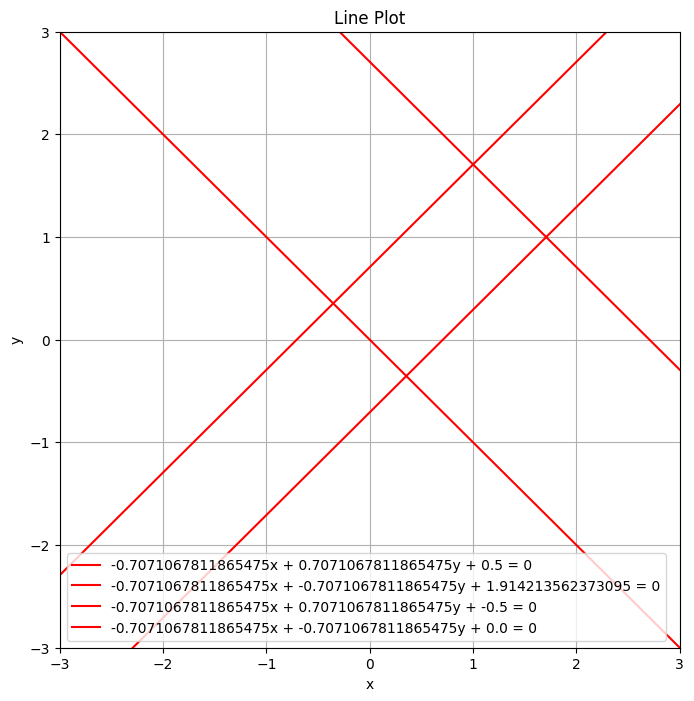

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple


def plot_lines(lines: List[np.array], x_range: Tuple[float, float] = (0, 2), y_range: Tuple[float, float] = (0, 2)):

    plt.figure(figsize=(8, 8))

    for line in lines:
        A, B, C = line
        x = np.linspace(x_range[0], x_range[1], 400)
        if B != 0:
            y = -(A * x + C) / B
        else:
            x = np.full_like(x, -C / A)
            y = np.linspace(y_range[0], y_range[1], 400)

        plt.plot(x, y, label=f'{A}x + {B}y + {C} = 0', color='red')

    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Line Plot')
    plt.legend()

    plt.show()


n2 = Node([1, 1], None, [])
n1 = Node([0, 0], 1, [n2])
print(f'len n1.sons {len(n1.sons)}')
lines = []
dfs(n1, None, None, lines, root=True)
print(lines)
D = 3

plot_lines(lines, (-D, D), (-D, D))

In [9]:
def lines_to_points(lines: List[np.array], verbose=False) -> List[np.array]:
    points = []
    for i in range(0, len(lines)):
        points.append(line_cross(lines[i - 1], lines[i]))
        if verbose:
            print(f'cross {lines[i - 1]} and {lines[i]} = {points[-1]}')
    return points

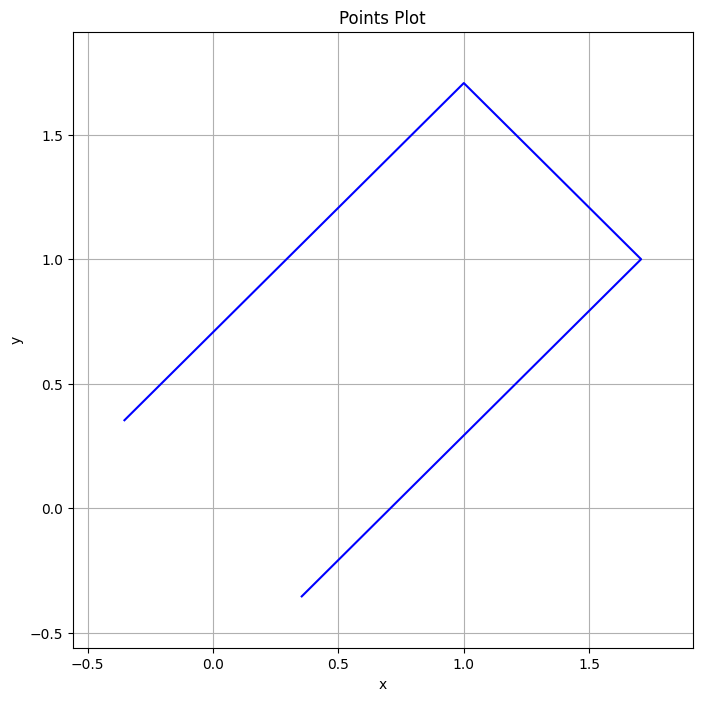

In [10]:
def plot_points_linked(pts: List[np.array]):
    pts = np.array(pts)
    x_max, x_min = np.max(pts[:, 0]), np.min(pts[:, 0])
    y_max, y_min = np.max(pts[:, 1]), np.min(pts[:, 1])
    x_mid = (x_max + x_min) / 2
    y_mid = (y_max + y_min) / 2
    width = max(x_max - x_min, y_max - y_min) * 1.2
    plt.figure(figsize=(8, 8))
    plt.plot(pts[:, 0], pts[:, 1], color='blue')
    plt.grid(True)
    plt.xlabel('x')
    plt.xlim(x_mid - width / 2, x_mid + width / 2)
    plt.ylim(y_mid - width / 2, y_mid + width / 2)
    plt.ylabel('y')
    plt.title('Points Plot')
    plt.show()


pts = lines_to_points(lines)
plot_points_linked(pts)

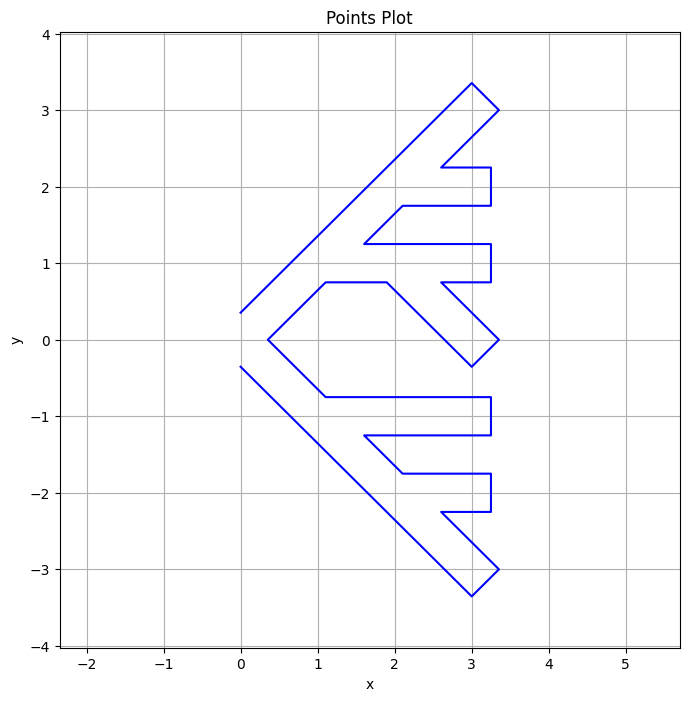

In [11]:
root = Node(pos=(0, 0), subtree_width=0.5, sons=[
    Node(pos=(1, 1), sons=[
        Node(pos=(2, 2), sons=[
            Node(pos=(3, 3)),
            Node(pos=(3, 2))
        ]),
        Node(pos=(2, 1), sons=[
            Node(pos=(3, 1)),
            Node(pos=(3, 0))
        ])
    ]),
    Node(pos=(1, -1), sons=[
        Node(pos=(2, -2), sons=[
            Node(pos=(3, -3)),
            Node(pos=(3, -2))
        ]),
        Node(pos=(2, -1), sons=[
            Node(pos=(3, -1)),
        ])
    ])
])
# root2 = \
#     Node(pos=(1, 1), subtree_width=0.5, sons=[
#         Node(pos=(2, 2), sons=[
#             Node(pos=(3, 2)),
#             Node(pos=(3, 3), subtree_width=0.25),
#         ]),
#     ])
# lines = []
# dfs(root, None, (1, 0), lines, root=True, verbose=False)
# pts = lines_to_points(lines, verbose=False)
# plot_points_linked(pts)


def tree_to_points(root: Node, up_dir=None) -> List[np.array]:
    lines = []
    dfs(root, None, up_dir, lines, root=True, verbose=False)
    return lines_to_points(lines, verbose=False)


plot_points_linked(tree_to_points(root, (1, 0)))

In [12]:
import copy
from abc import abstractmethod
from typing import Protocol


class M1(Protocol):
    @abstractmethod
    def get_pos(self):
        pass

    @abstractmethod
    def get_width(self):
        pass

    @abstractmethod
    def to_tree(self, m1_fa=None) -> Node:
        pass


class RectM1(M1):
    def __init__(self, p1, p3, w=None, sons=[], ovr_dir=None):
        self.p1 = p1
        self.p3 = p3
        self.w = w  # w 是最终管道距离。矩形间距是其 2 倍
        self.sons: List[M1] = sons  # ele must be tuple (eid, M1)
        self.ovr_dir = ovr_dir

    #
    def get_pos(self):
        return self.p1

    # @abs
    def get_width(self):
        return self.w

    # @abs
    def to_tree(self, m1_fa: M1 = None) -> Node:
        if self.w is None:
            assert (m1_fa is not None)
            self.w = m1_fa.get_width()
        dir = self.ovr_dir if self.ovr_dir is not None else normalized(
            self.p1 - m1_fa.get_pos())
        rect_width = self.w * 2.0
        p2 = line_cross(line_at_dir(self.p1, dir),
                        line_at_dir(self.p3, dir_left(dir)))
        p4 = line_cross(line_at_dir(self.p3, dir),
                        line_at_dir(self.p1, dir_left(dir)))
        p5 = self.p1 + dir_left(dir) * rect_width
        # root = Node(rect.p1, rect.w, [])
        q = [
            (self.p1, dir),
            (p2, dir_left(dir)),
            (self.p3, dir_left(dir_left(dir))),
            (p4, dir_left(dir_left(dir_left(dir)))),
            (p5, dir),
        ]
        while True:
            u, dir = q[-1]
            same_corner, s_dir = q[-4]
            v, v_dir = up_left(same_corner, s_dir,
                               rect_width, rect_width), s_dir
            if norm(v - u) > rect_width / 2.0:
                q.append((v, v_dir))
            if norm(v - u) < rect_width:
                break
        rt = Node(q[0][0], self.w, [])
        u = rt
        for i in range(1, len(q)):
            u.sons.append(Node(q[i][0], self.w, []))
            u = u.sons[0]

        # [eid]
        out: List[Node] = [
            rt, rt.sons[0], rt.sons[0].sons[0], rt.sons[0].sons[0].sons[0], rt.sons[0].sons[0].sons[0].sons[0]
        ]
        # [todo] 有问题
        for eid, m1 in self.sons:
            dir = normalized(out[eid + 1].pos - out[eid].pos)
            link = line_cross(line_at_dir(out[eid].pos, dir), line_at_dir(
                m1.get_link_pos(), dir_left(dir)))
            m1_tree: Node = m1.to_tree(self)
            copied_sons = [copy.copy(ele) for ele in out[eid].sons]
            out[eid].sons = [Node(link, None, copied_sons)]
            out[eid].sons[0].sons.append(m1_tree)
        return rt


class NodeM1(M1):
    def __init__(self, pos, w=None, sons=[]):
        self.pos = pos
        self.w = w
        self.sons: List[M1] = sons  # list of m1

    def get_pos(self):
        return self.pos

    def get_width(self):
        return self.w

    def to_tree(self, fa=None) -> Node:
        print('ok')
        return Node(self.pos, self.w, [son.to_tree(self) for son in self.sons])

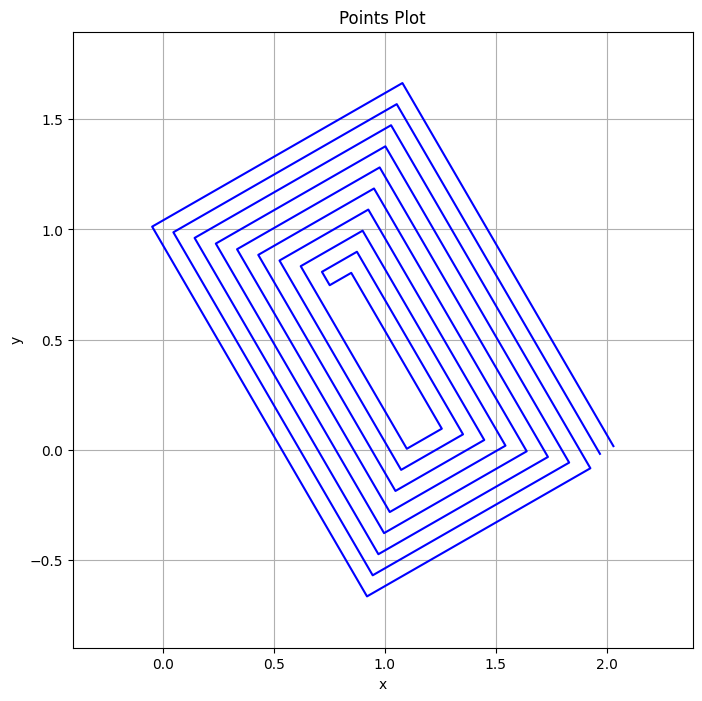

In [13]:
dx = -0.5
root = \
    RectM1(np.array([2, 0]), np.array([0, 1]), 0.07, ovr_dir=np.array([dx, (1 - dx ** 2) ** 0.5])).to_tree(
        None)

plot_points_linked(tree_to_points(root, None, ))

ok


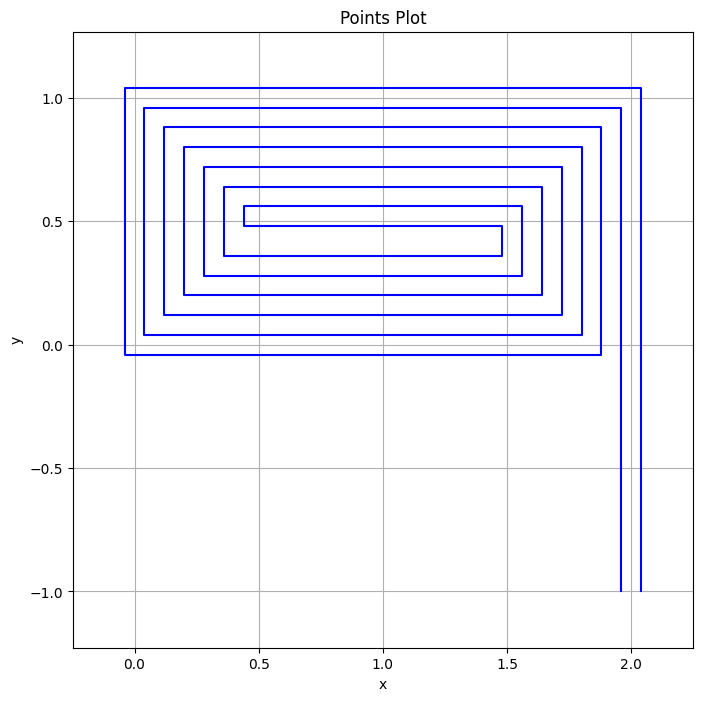

In [14]:
w = 0.08
m1_rt = NodeM1(pos=np.array([2, -1]), w=w, sons=[
    RectM1(np.array([2, 0]), np.array([0, 1]),
           w=w),
])
m0_rt = m1_rt.to_tree()
plot_points_linked(tree_to_points(m0_rt, None))